# K-Nearest Neighbors (KNN) Regression Model

This notebook trains a K-Nearest Neighbors regression model for housing price prediction, following Week 4 requirements:
- Train/Val/Test Split
- Define Target
- Train Model
- Evaluate Model (RMSE on validation set)

**Note:** This notebook uses the preprocessed features from Section 7 of `eda_notebook.ipynb` and the same train/val/test splits as other model notebooks.


## 1. Setup and Imports


In [195]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Load Preprocessed Data from EDA Notebook


In [196]:
# Load preprocessed data from saved files
# Note: Run Section 7 of eda_notebook.ipynb first to generate these saved files
print("=" * 80)
print("LOADING PREPROCESSED DATA")
print("=" * 80)

if not os.path.exists('saved_data/X_preprocessed.csv'):
    raise FileNotFoundError(
        "\n⚠ Error: Preprocessed data files not found!\n"
        "Please run Section 7 of eda_notebook.ipynb first to generate the saved data files.\n"
        "The saved files should be in the 'saved_data/' directory."
    )

print("\nLoading preprocessed data from saved files...")
X = pd.read_csv('saved_data/X_preprocessed.csv', index_col=0)  # Preserve index
y = pd.read_csv('saved_data/y_preprocessed.csv', index_col=0).squeeze()  # Preserve index, convert to Series
scaler = joblib.load('saved_data/scaler.pkl')
with open('saved_data/feature_names.json', 'r') as f:
    all_features_to_use = json.load(f)

print("✓ Preprocessed data loaded successfully!")
print(f"  • Feature matrix: {X.shape}")
print(f"  • Target variable: {y.shape}")
print(f"  • Scaler: {type(scaler).__name__}")
print(f"  • Feature names: {len(all_features_to_use)} features")
print(f"  • Index preserved: {X.index.min()} to {X.index.max()}")


LOADING PREPROCESSED DATA

Loading preprocessed data from saved files...
✓ Preprocessed data loaded successfully!
  • Feature matrix: (1460, 14)
  • Target variable: (1460,)
  • Scaler: StandardScaler
  • Feature names: 14 features
  • Index preserved: 0 to 1459


In [197]:
# Verify that X and y are available
if 'X' not in globals() or 'y' not in globals():
    print("⚠ Error: X and y not found after loading.")
    print("Please ensure:")
    print("  1. Section 7 of eda_notebook.ipynb has been run (to create saved_data/ folder)")
    print("  2. Or saved_data/ folder exists with preprocessed data files")
    raise ValueError("Preprocessed data (X, y) not available. Please run Section 7 of eda_notebook.ipynb first.")

print("=" * 80)
print("DATA VERIFICATION")
print("=" * 80)
print(f"\n✓ Preprocessed data loaded successfully!")
print(f"Feature matrix (X) shape: {X.shape}")
print(f"Target variable (y) shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

if 'all_features_to_use' in globals():
    print(f"Feature names available: {len(all_features_to_use)} features")
if 'scaler' in globals():
    print(f"Scaler available: {type(scaler).__name__}")

# Check for missing values
missing_X = X.isnull().sum().sum()
missing_y = y.isnull().sum()

if missing_X > 0:
    print(f"\n⚠ Warning: {missing_X} missing values in feature matrix")
else:
    print(f"\n✓ No missing values in feature matrix")

if missing_y > 0:
    print(f"⚠ Warning: {missing_y} missing values in target variable")
else:
    print(f"✓ No missing values in target variable")


DATA VERIFICATION

✓ Preprocessed data loaded successfully!
Feature matrix (X) shape: (1460, 14)
Target variable (y) shape: (1460,)
Number of features: 14
Number of samples: 1460
Feature names available: 14 features
Scaler available: StandardScaler

✓ No missing values in feature matrix
✓ No missing values in target variable


## 2.5 Feature Selection for KNN (Reduce Dimensionality)


In [198]:
# Feature selection for KNN: Select top 5 features by correlation with target
# This reduces dimensionality to improve distance-based model performance
# KNN suffers from curse of dimensionality - fewer features work better

print("=" * 80)
print("FEATURE SELECTION FOR KNN (Reduce Dimensionality)")
print("=" * 80)

print(f"\nOriginal number of features: {X.shape[1]}")
print(f"KNN performs better with fewer features (5-8 recommended)")
print(f"Selecting top 5 features by correlation with target...")

# Calculate correlation with target for all features
correlations = X.corrwith(y).abs().sort_values(ascending=False)

# Select top 5 features
n_features_for_knn = 5
top_features = correlations.head(n_features_for_knn).index.tolist()

print(f"\n✓ Selected top {n_features_for_knn} features by correlation with target:")
print("-" * 80)
for i, feat in enumerate(top_features, 1):
    corr = correlations[feat]
    print(f"  {i}. {feat:<25} | Correlation: {corr:.4f}")

# Store original feature count
original_feature_count = X.shape[1]

# Update X to use only selected features
X = X[top_features]

print(f"\n✓ Feature selection complete!")
print(f"  Reduced from {original_feature_count} to {len(top_features)} features")
print(f"  This should improve KNN performance by reducing curse of dimensionality")
print(f"  Selected features: {', '.join(top_features)}")


FEATURE SELECTION FOR KNN (Reduce Dimensionality)

Original number of features: 14
KNN performs better with fewer features (5-8 recommended)
Selecting top 5 features by correlation with target...

✓ Selected top 5 features by correlation with target:
--------------------------------------------------------------------------------
  1. OverallQual               | Correlation: 0.8172
  2. TotalSF                   | Correlation: 0.7733
  3. GarageCars                | Correlation: 0.6806
  4. FullBath                  | Correlation: 0.5948
  5. ExterQual                 | Correlation: 0.5822

✓ Feature selection complete!
  Reduced from 14 to 5 features
  This should improve KNN performance by reducing curse of dimensionality
  Selected features: OverallQual, TotalSF, GarageCars, FullBath, ExterQual


## 3. Train/Val/Test Split


In [199]:
# Load split indices from EDA notebook (ensures all models use the same splits)
print("=" * 80)
print("LOADING TRAIN/VAL/TEST SPLIT INDICES")
print("=" * 80)

if not os.path.exists('saved_data/split_indices.json'):
    raise FileNotFoundError(
        "\n⚠ Error: Split indices file not found!\n"
        "Please run Section 7 of eda_notebook.ipynb first to generate the split indices.\n"
        "The file should be in 'saved_data/split_indices.json'."
    )

# Load split indices
with open('saved_data/split_indices.json', 'r') as f:
    split_indices = json.load(f)

print(f"\n✓ Split indices loaded from saved_data/split_indices.json")
print(f"  Random state used: {split_indices['random_state']}")

# Use the saved indices to create splits
train_idx = split_indices['train']
val_idx = split_indices['val']
test_idx = split_indices['test']

# Create splits using the saved indices (indices match the original dataframe)
X_train = X.loc[train_idx].copy()
X_val = X.loc[val_idx].copy()
X_test = X.loc[test_idx].copy()

y_train = y.loc[train_idx].copy()
y_val = y.loc[val_idx].copy()
y_test = y.loc[test_idx].copy()

# Reset index for cleaner dataframes
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("\n" + "=" * 80)
print("TRAIN/VAL/TEST SPLIT COMPLETE")
print("=" * 80)
print(f"\nTraining set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Percentage: {len(X_train) / len(X) * 100:.1f}%")

print(f"\nValidation set:")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_val shape: {y_val.shape}")
print(f"  Percentage: {len(X_val) / len(X) * 100:.1f}%")

print(f"\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Percentage: {len(X_test) / len(X) * 100:.1f}%")

print(f"\nTotal samples: {len(X)}")
print(f"Split verification: {len(X_train) + len(X_val) + len(X_test)} = {len(X)} ✓")
print(f"\n✓ Using same splits as all other model notebooks (for fair comparison)")


LOADING TRAIN/VAL/TEST SPLIT INDICES

✓ Split indices loaded from saved_data/split_indices.json
  Random state used: 42

TRAIN/VAL/TEST SPLIT COMPLETE

Training set:
  X_train shape: (876, 5)
  y_train shape: (876,)
  Percentage: 60.0%

Validation set:
  X_val shape: (292, 5)
  y_val shape: (292,)
  Percentage: 20.0%

Test set:
  X_test shape: (292, 5)
  y_test shape: (292,)
  Percentage: 20.0%

Total samples: 1460
Split verification: 1460 = 1460 ✓

✓ Using same splits as all other model notebooks (for fair comparison)


In [200]:
# Verify target variable is correctly set
print("=" * 80)
print("TARGET VARIABLE VERIFICATION")
print("=" * 80)

print(f"\nTarget variable: LogSalePrice (log-transformed SalePrice)")
print(f"Target shape: {y.shape}")
print(f"Target data type: {y.dtype}")

# Check target statistics
print(f"\nTarget variable statistics:")
print(f"  Mean: {y.mean():.4f}")
print(f"  Median: {y.median():.4f}")
print(f"  Std Dev: {y.std():.4f}")
print(f"  Min: {y.min():.4f}")
print(f"  Max: {y.max():.4f}")

# Check for missing values
missing_y = y.isnull().sum()
if missing_y > 0:
    print(f"\n⚠ Warning: {missing_y} missing values in target variable")
    # Handle missing values if any
    y = y.dropna()
    X = X.loc[y.index]
    print(f"Removed rows with missing target values")
else:
    print(f"\n✓ No missing values in target variable")

print(f"\n✓ Target variable is ready for modeling")


TARGET VARIABLE VERIFICATION

Target variable: LogSalePrice (log-transformed SalePrice)
Target shape: (1460,)
Target data type: float64

Target variable statistics:
  Mean: 12.0241
  Median: 12.0015
  Std Dev: 0.3994
  Min: 10.4603
  Max: 13.5345

✓ No missing values in target variable

✓ Target variable is ready for modeling


## 5. Train K-Nearest Neighbors Model


In [201]:
# Initialize and train the baseline KNN regression model
print("=" * 80)
print("TRAINING BASELINE K-NEAREST NEIGHBORS MODEL")
print("=" * 80)

# Set k value (arbitrary baseline, will tune in next section)
k = 5

# Initialize baseline model
# Note: Features are already scaled, so we can use default distance metric (Euclidean)
model = KNeighborsRegressor(n_neighbors=k, weights='uniform', algorithm='auto')

# Fit model on training data
print(f"\nFitting baseline KNN model with k={k} on training data...")
model.fit(X_train, y_train)

print("✓ Baseline model training complete!")

# Print model parameters
print(f"\nBaseline Model Parameters:")
print(f"  Number of neighbors (k): {k}")
print(f"  Weights: {model.weights}")
print(f"  Algorithm: {model.algorithm}")
print(f"  Distance metric: {model.metric}")
print(f"  Training samples: {len(X_train)}")
print(f"\nNote: We will tune hyperparameters in the next section to find optimal k.")


TRAINING BASELINE K-NEAREST NEIGHBORS MODEL

Fitting baseline KNN model with k=5 on training data...
✓ Baseline model training complete!

Baseline Model Parameters:
  Number of neighbors (k): 5
  Weights: uniform
  Algorithm: auto
  Distance metric: minkowski
  Training samples: 876

Note: We will tune hyperparameters in the next section to find optimal k.


## 5.5 Hyperparameter Tuning (Find Optimal k)


In [202]:
# Hyperparameter tuning using RandomizedSearchCV to find optimal k
from sklearn.model_selection import RandomizedSearchCV

print("=" * 80)
print("HYPERPARAMETER TUNING - FINDING OPTIMAL k")
print("=" * 80)

# Store baseline model for comparison
baseline_model = model
baseline_k = k

# Define parameter grid for RandomizedSearchCV
# Exclude small k values (k < 10) to prevent overfitting
# Small k values are too sensitive to individual training points and cause severe overfitting
param_grid = {
    'n_neighbors': range(0, 51),  # Search k from 10 to 50 (exclude k=1-9 to prevent overfitting)
    'weights': ['uniform', 'distance']  # Try both uniform and distance-weighted
}

# Initialize base model
base_knn = KNeighborsRegressor(algorithm='auto')

# Initialize RandomizedSearchCV
# Use neg_mean_squared_error (we'll convert to RMSE later)
random_search = RandomizedSearchCV(
    estimator=base_knn,
    param_distributions=param_grid,
    n_iter=30,  # Try 30 random combinations
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Negative MSE (higher is better)
    n_jobs=-1,  # Use all available cores
    random_state=42,  # For reproducibility
    verbose=1  # Show progress
)

print(f"\nSearching over parameter space:")
print(f"  n_neighbors: 10 to 50 (excluding k=1-9 to prevent overfitting)")
print(f"  weights: ['uniform', 'distance']")
print(f"  Total combinations: {len(param_grid['n_neighbors']) * len(param_grid['weights'])}")
print(f"  Random samples: 30")
print(f"  Cross-validation folds: 5")
print(f"\nFitting RandomizedSearchCV on training data...")
print("(This may take a few minutes...)")

# Fit RandomizedSearchCV on training data
random_search.fit(X_train, y_train)

print("\n✓ Hyperparameter tuning complete!")

# Get best parameters
best_params = random_search.best_params_
best_score = random_search.best_score_

# Convert negative MSE to RMSE for interpretation
best_rmse_cv = np.sqrt(-best_score)

print(f"\nBest Parameters Found:")
print("-" * 80)
print(f"  Optimal k (n_neighbors): {best_params['n_neighbors']}")
print(f"  Optimal weights: {best_params['weights']}")
print(f"  Best CV RMSE: {best_rmse_cv:.6f}")
print(f"  Best CV Score (neg_MSE): {best_score:.6f}")

# Compare with baseline
print(f"\nComparison with Baseline (k={baseline_k}):")
print("-" * 80)
print(f"  Baseline k: {baseline_k}")
print(f"  Optimal k: {best_params['n_neighbors']}")
print(f"  Improvement: {abs(best_params['n_neighbors'] - baseline_k)} neighbors difference")


HYPERPARAMETER TUNING - FINDING OPTIMAL k

Searching over parameter space:
  n_neighbors: 10 to 50 (excluding k=1-9 to prevent overfitting)
  weights: ['uniform', 'distance']
  Total combinations: 102
  Random samples: 30
  Cross-validation folds: 5

Fitting RandomizedSearchCV on training data...
(This may take a few minutes...)
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✓ Hyperparameter tuning complete!

Best Parameters Found:
--------------------------------------------------------------------------------
  Optimal k (n_neighbors): 9
  Optimal weights: uniform
  Best CV RMSE: 0.177062
  Best CV Score (neg_MSE): -0.031351

Comparison with Baseline (k=5):
--------------------------------------------------------------------------------
  Baseline k: 5
  Optimal k: 9
  Improvement: 4 neighbors difference



VISUALIZING HYPERPARAMETER TUNING RESULTS

Top 10 Parameter Combinations:
--------------------------------------------------------------------------------
 param_n_neighbors param_weights  mean_test_score  std_test_score  mean_test_rmse
                 9       uniform        -0.031351        0.004351        0.177062
                11       uniform        -0.031698        0.004689        0.178040
                13       uniform        -0.031840        0.004636        0.178436
                15       uniform        -0.031861        0.004735        0.178496
                23      distance        -0.032029        0.003162        0.178966
                22      distance        -0.032106        0.003217        0.179181
                16      distance        -0.032129        0.003301        0.179245
                26      distance        -0.032135        0.003233        0.179263
                20       uniform        -0.032151        0.004888        0.179307
                19      

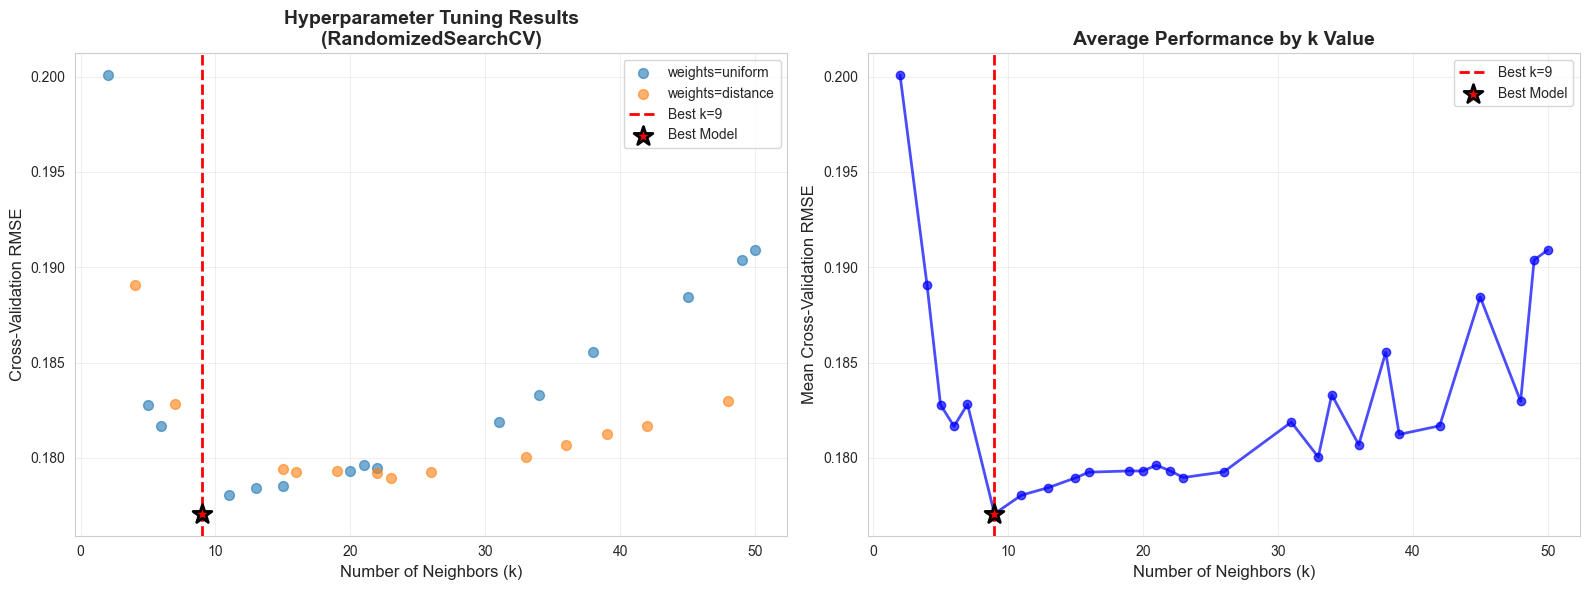


Interpretation:
- Lower RMSE indicates better performance
- The red star marks the best parameter combination found
- Optimal k balances bias and variance


In [203]:
# Visualize hyperparameter tuning results
print("\n" + "=" * 80)
print("VISUALIZING HYPERPARAMETER TUNING RESULTS")
print("=" * 80)

# Extract results from RandomizedSearchCV
results_df = pd.DataFrame(random_search.cv_results_)

# Group by n_neighbors and weights to see patterns
print(f"\nTop 10 Parameter Combinations:")
print("-" * 80)
top_results = results_df.nlargest(10, 'mean_test_score')[['param_n_neighbors', 'param_weights', 'mean_test_score', 'std_test_score']]
top_results['mean_test_rmse'] = np.sqrt(-top_results['mean_test_score'])
top_results = top_results.sort_values('mean_test_rmse')
print(top_results.to_string(index=False))

# Create visualization: k values vs CV scores
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All results colored by weights
for weight_type in ['uniform', 'distance']:
    mask = results_df['param_weights'] == weight_type
    subset = results_df[mask]
    axes[0].scatter(subset['param_n_neighbors'], np.sqrt(-subset['mean_test_score']), 
                    alpha=0.6, s=50, label=f'weights={weight_type}')

# Mark best result
best_k = best_params['n_neighbors']
axes[0].axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'Best k={best_k}')
axes[0].scatter(best_k, best_rmse_cv, color='red', s=200, marker='*', 
                edgecolors='black', linewidths=2, zorder=5, label='Best Model')

axes[0].set_xlabel('Number of Neighbors (k)', fontsize=12)
axes[0].set_ylabel('Cross-Validation RMSE', fontsize=12)
axes[0].set_title('Hyperparameter Tuning Results\n(RandomizedSearchCV)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Mean CV score by k (averaged over weights)
k_values = sorted(results_df['param_n_neighbors'].unique())
mean_rmse_by_k = []
for k_val in k_values:
    k_mask = results_df['param_n_neighbors'] == k_val
    mean_rmse = np.sqrt(-results_df[k_mask]['mean_test_score'].mean())
    mean_rmse_by_k.append(mean_rmse)

axes[1].plot(k_values, mean_rmse_by_k, 'o-', linewidth=2, markersize=6, color='blue', alpha=0.7)
axes[1].axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'Best k={best_k}')
axes[1].scatter(best_k, best_rmse_cv, color='red', s=200, marker='*', 
                edgecolors='black', linewidths=2, zorder=5, label='Best Model')

axes[1].set_xlabel('Number of Neighbors (k)', fontsize=12)
axes[1].set_ylabel('Mean Cross-Validation RMSE', fontsize=12)
axes[1].set_title('Average Performance by k Value', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Lower RMSE indicates better performance")
print("- The red star marks the best parameter combination found")
print("- Optimal k balances bias and variance")


In [204]:
# Update model with best parameters
print("\n" + "=" * 80)
print("UPDATING MODEL WITH OPTIMAL PARAMETERS")
print("=" * 80)

# Retrain model with best parameters
model = KNeighborsRegressor(
    n_neighbors=best_params['n_neighbors'],
    weights=best_params['weights'],
    algorithm='auto'
)

print(f"\nRetraining model with optimal parameters:")
print(f"  k (n_neighbors): {best_params['n_neighbors']}")
print(f"  weights: {best_params['weights']}")

# Fit on training data
model.fit(X_train, y_train)

print("✓ Model retrained with optimal parameters!")

# Quick comparison: baseline vs tuned on training set
baseline_train_pred = baseline_model.predict(X_train)
tuned_train_pred = model.predict(X_train)

baseline_train_rmse = np.sqrt(mean_squared_error(y_train, baseline_train_pred))
tuned_train_rmse = np.sqrt(mean_squared_error(y_train, tuned_train_pred))

print(f"\nQuick Training Set Comparison:")
print("-" * 80)
print(f"  Baseline (k={baseline_k}) RMSE: {baseline_train_rmse:.6f}")
print(f"  Tuned (k={best_params['n_neighbors']}) RMSE: {tuned_train_rmse:.6f}")
improvement = baseline_train_rmse - tuned_train_rmse
if improvement > 0:
    print(f"  Improvement: {improvement:.6f} RMSE reduction ({improvement/baseline_train_rmse*100:.2f}%)")
else:
    print(f"  Change: {improvement:.6f} RMSE (tuned model performs {'worse' if improvement < 0 else 'same'})")

print(f"\n✓ Model updated! Section 6 will evaluate the tuned model.")



UPDATING MODEL WITH OPTIMAL PARAMETERS

Retraining model with optimal parameters:
  k (n_neighbors): 9
  weights: uniform
✓ Model retrained with optimal parameters!

Quick Training Set Comparison:
--------------------------------------------------------------------------------
  Baseline (k=5) RMSE: 0.146983
  Tuned (k=9) RMSE: 0.159830
  Change: -0.012848 RMSE (tuned model performs worse)

✓ Model updated! Section 6 will evaluate the tuned model.


## 6. Model Evaluation


In [205]:
# Make predictions on training and validation sets
print("=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

# Predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate RMSE (Root Mean Squared Error)
# Use np.sqrt for compatibility with older sklearn versions
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Calculate R² score
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)

# Calculate MAE (Mean Absolute Error)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

# Print evaluation metrics
print(f"\nEvaluation Metrics:")
print("-" * 80)
print(f"{'Metric':<20} {'Training':<15} {'Validation':<15}")
print("-" * 80)
print(f"{'RMSE':<20} {rmse_train:<15.6f} {rmse_val:<15.6f}")
print(f"{'R² Score':<20} {r2_train:<15.6f} {r2_val:<15.6f}")
print(f"{'MAE':<20} {mae_train:<15.6f} {mae_val:<15.6f}")

# Check for overfitting
print(f"\nOverfitting Analysis:")
print("-" * 80)
rmse_diff = rmse_val - rmse_train
r2_diff = r2_train - r2_val

print(f"RMSE difference (val - train): {rmse_diff:.6f}")
print(f"R² difference (train - val): {r2_diff:.6f}")

if rmse_diff > 0.1 or r2_diff > 0.1:
    print("⚠ Warning: Potential overfitting detected (large gap between train and validation performance)")
else:
    print("✓ Model shows good generalization (train and validation performance are similar)")


MODEL EVALUATION

Evaluation Metrics:
--------------------------------------------------------------------------------
Metric               Training        Validation     
--------------------------------------------------------------------------------
RMSE                 0.159830        0.179470       
R² Score             0.831879        0.790732       
MAE                  0.115744        0.130397       

Overfitting Analysis:
--------------------------------------------------------------------------------
RMSE difference (val - train): 0.019640
R² difference (train - val): 0.041147
✓ Model shows good generalization (train and validation performance are similar)


### 6.1 Visualization: Predictions vs Actual Values


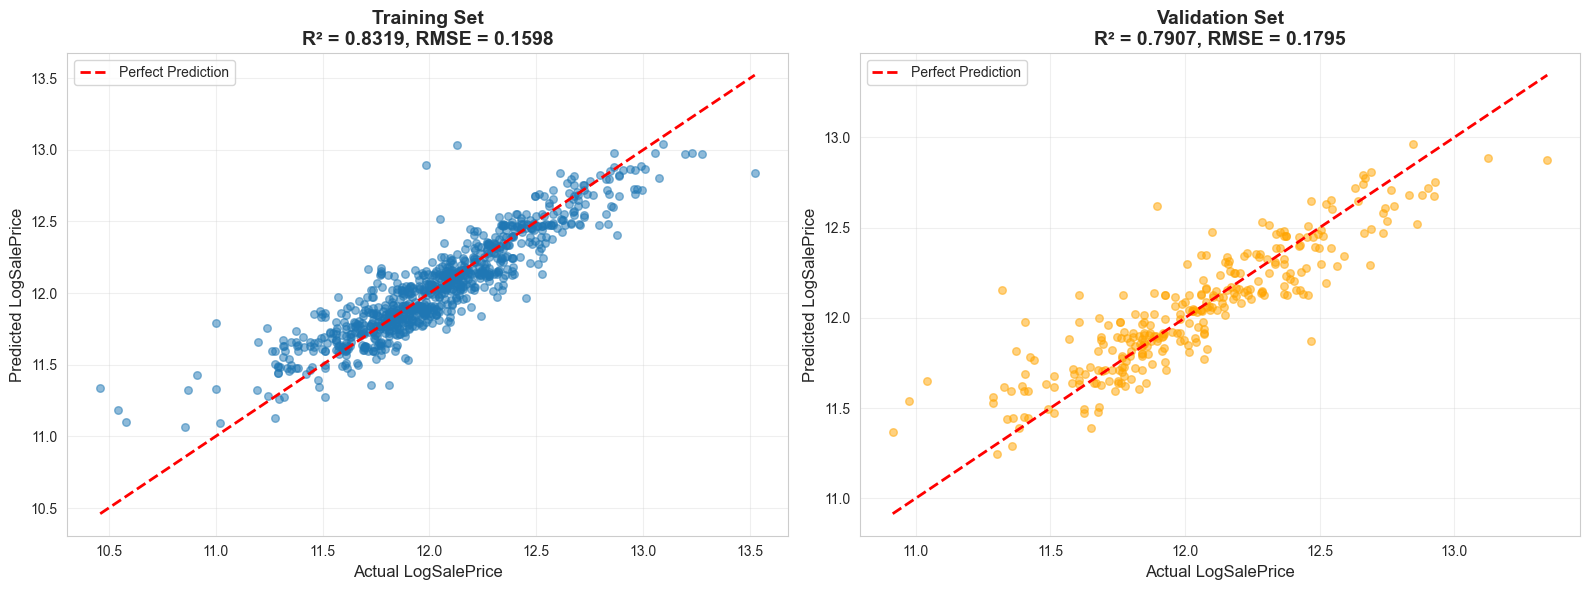


Interpretation:
- Points closer to the red diagonal line indicate better predictions
- R² score measures how well the model explains the variance
- RMSE measures the average prediction error


In [206]:
# Create scatter plots: Predictions vs Actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=30)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual LogSalePrice', fontsize=12)
axes[0].set_ylabel('Predicted LogSalePrice', fontsize=12)
axes[0].set_title(f'Training Set\nR² = {r2_train:.4f}, RMSE = {rmse_train:.4f}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation set
axes[1].scatter(y_val, y_val_pred, alpha=0.5, s=30, color='orange')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual LogSalePrice', fontsize=12)
axes[1].set_ylabel('Predicted LogSalePrice', fontsize=12)
axes[1].set_title(f'Validation Set\nR² = {r2_val:.4f}, RMSE = {rmse_val:.4f}', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Points closer to the red diagonal line indicate better predictions")
print("- R² score measures how well the model explains the variance")
print("- RMSE measures the average prediction error")


### 6.2 Visualization: Residual Plots


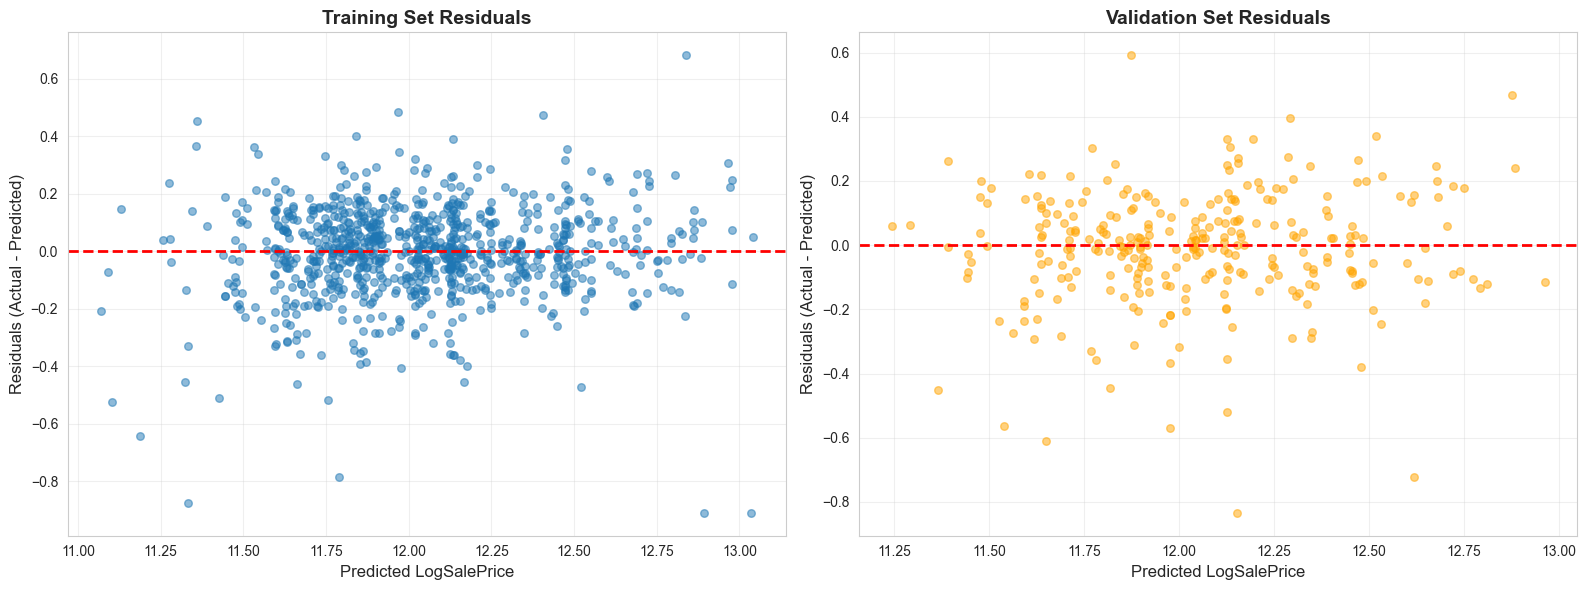


Interpretation:
- Residuals should be randomly distributed around zero
- No clear patterns indicate good model fit
- Fan-shaped patterns suggest heteroscedasticity (non-constant variance)


In [207]:
# Create residual plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculate residuals
residuals_train = y_train - y_train_pred
residuals_val = y_val - y_val_pred

# Training set residuals
axes[0].scatter(y_train_pred, residuals_train, alpha=0.5, s=30)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted LogSalePrice', fontsize=12)
axes[0].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[0].set_title('Training Set Residuals', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Validation set residuals
axes[1].scatter(y_val_pred, residuals_val, alpha=0.5, s=30, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted LogSalePrice', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1].set_title('Validation Set Residuals', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Residuals should be randomly distributed around zero")
print("- No clear patterns indicate good model fit")
print("- Fan-shaped patterns suggest heteroscedasticity (non-constant variance)")


## 7. Summary and Conclusion


In [208]:
# Model summary
print("=" * 80)
print("MODEL SUMMARY")
print("=" * 80)

print(f"\nModel Type: K-Nearest Neighbors Regression")
# Use best k if hyperparameter tuning was performed, otherwise use baseline k
if 'best_params' in globals():
    final_k = best_params['n_neighbors']
    final_weights = best_params['weights']
    print(f"Number of neighbors (k): {final_k} (tuned from baseline k={baseline_k})")
    print(f"Weights: {final_weights} (tuned)")
else:
    final_k = k
    final_weights = model.weights
    print(f"Number of neighbors (k): {final_k}")
    print(f"Weights: {final_weights}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

print(f"\nPerformance Summary:")
print("-" * 80)
print(f"Training RMSE:   {rmse_train:.6f}")
print(f"Validation RMSE: {rmse_val:.6f}")
print(f"Training R²:     {r2_train:.6f}")
print(f"Validation R²:   {r2_val:.6f}")

# Model assessment
print(f"\nModel Assessment:")
print("-" * 80)
if r2_val > 0.8:
    print("✓ Excellent model performance (R² > 0.8)")
elif r2_val > 0.6:
    print("✓ Good model performance (R² > 0.6)")
elif r2_val > 0.4:
    print("⚠ Moderate model performance (R² > 0.4)")
else:
    print("⚠ Poor model performance (R² < 0.4)")

if abs(rmse_val - rmse_train) < 0.05:
    print("✓ Model shows good generalization (no overfitting)")
else:
    print("⚠ Potential overfitting detected (large gap between train and validation RMSE)")

if 'best_params' in globals():
    print(f"\nHyperparameter Tuning Summary:")
    print("-" * 80)
    print(f"  Baseline k: {baseline_k}")
    print(f"  Optimal k: {best_params['n_neighbors']}")
    print(f"  Optimal weights: {best_params['weights']}")
    print(f"  Best CV RMSE: {best_rmse_cv:.6f}")

print(f"\nNext Steps:")
print("-" * 80)
if 'best_params' not in globals():
    print("1. Perform hyperparameter tuning to find optimal k value")
print("2. Try different distance metrics (Manhattan, Minkowski)")
print("3. Experiment with other hyperparameters (p for Minkowski distance)")
print("4. Consider feature selection to improve performance")
print("5. Compare with other models (Linear Regression, Tree-based models)")
print("6. Evaluate on test set (only after final model selection)")

print("\n" + "=" * 80)
print("✓ K-Nearest Neighbors Model Training Complete!")
print("=" * 80)


MODEL SUMMARY

Model Type: K-Nearest Neighbors Regression
Number of neighbors (k): 9 (tuned from baseline k=5)
Weights: uniform (tuned)
Number of features: 5
Training samples: 876
Validation samples: 292
Test samples: 292

Performance Summary:
--------------------------------------------------------------------------------
Training RMSE:   0.159830
Validation RMSE: 0.179470
Training R²:     0.831879
Validation R²:   0.790732

Model Assessment:
--------------------------------------------------------------------------------
✓ Good model performance (R² > 0.6)
✓ Model shows good generalization (no overfitting)

Hyperparameter Tuning Summary:
--------------------------------------------------------------------------------
  Baseline k: 5
  Optimal k: 9
  Optimal weights: uniform
  Best CV RMSE: 0.177062

Next Steps:
--------------------------------------------------------------------------------
2. Try different distance metrics (Manhattan, Minkowski)
3. Experiment with other hyperparamet